# Model implementation

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [20]:
%load_ext autoreload
%autoreload 2

import os
import time
import tqdm
import numpy as np
import pandas as pd

import vis
import softclustering as sc

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import socceraction.spadl as spadl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

Concatenate actions of all games in one DataFrame.

In [21]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 177.80it/s]


In [22]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx, "corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx, "freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx, "keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name == "shot_penalty", 94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name == "shot_penalty", 34)

    return actions


actions = consolidate(actions)

In [23]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [24]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Dribble
    * Pass
    * Keeper_action
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Throw_in
    * Corner
    * Freekick
    * Shot_penalty

In [25]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "dribble", "pass", "keeper_action", "clearance", "goalkick"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "dribble", "pass", "keeper_action", "throw_in", "corner", "freekick", "shot_penalty"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions


actions = add_noise(actions)

In [26]:
# # display event locations with noise
# corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
# for actiontype in corrected_actions:
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="start_x",
#         y="start_y",
#         title = f"Start Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="end_x",
#         y="end_y",
#         title = f"End Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()

In [27]:
def remove_outliers(actions, verbose=False):
    X = actions[["start_x","start_y","end_x","end_y"]].to_numpy(dtype=float)
    inliers = LocalOutlierFactor(contamination="auto").fit_predict(X)
    if verbose:
        print(f"Remove {(inliers==-1).sum()} out of {X.shape[0]} datapoints.")
    return actions[inliers==1]

actions = remove_outliers(actions,True)

Remove 532 out of 128484 datapoints.


### Features

Compute the angle of the direction of the action with respect with the x-axis (pitch's length) a
$$\tan \theta = \frac{y_{end} - y_{start}}{x_{end} - x_{start}}$$

In [28]:
actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
actions["cos_angle"] = np.cos(actions["angle"])
actions["sin_angle"] = np.sin(actions["angle"])
actions[["angle", "cos_angle", "sin_angle"]].describe()

,angle,cos_angle,sin_angle
count,127952.000000,127952.000000,127952.000000
mean,-0.009049,0.278094,-0.005516
std,1.499915,0.680444,0.677965
min,-3.141565,-1.000000,-1.000000
25%,-1.096262,-0.267098,-0.662257
50%,0.000000,0.471879,0.000000
75%,1.061082,0.926051,0.644750
max,3.141411,1.000000,1.000000


### First run

Let's run a first toy implementation using throw-ins of team France.

In [29]:
mask = (actions["type_name"]=="dribble") & (actions["team_id"]==771)
loc_data = actions[mask][["start_x", "start_y"]]
dir_data = actions[mask][["cos_angle", "sin_angle"]]

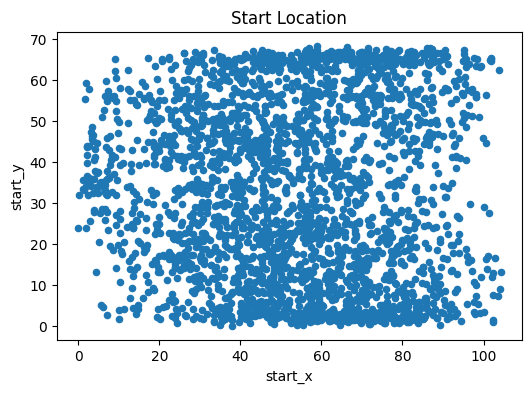

In [30]:
loc_data.plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location",
        figsize = (6,4)
    )
plt.show()

In [31]:
# Gaussian clusters
k_gauss = 4
all_results = []

for init in ["k-means++", "k-means", "random", "random_from_data"]:
    times = {}
    results = {}
    models = {}

    for case in ["classic", "bregman"]:
        loc_model = sc.MixtureModel(
            [sc.MultivariateGaussian() for _ in range(k_gauss)],
            init=init
        )
        start = time.time()
        results[case] = loc_model.fit_em(loc_data, verbose=False, case=case)
        times[case] = time.time() - start
        models[case] = loc_model

        all_results.append({
            "initialization": init,
            "case": case,
            "log_likelihood": results[case][-1],
            "time_sec": times[case],
            "ch_score": models[case].kl_ch_score(loc_data)
        })

loc_results = pd.DataFrame(all_results)
loc_results

,initialization,case,log_likelihood,time_sec,ch_score
0,k-means++,classic,-25236.619312,0.705398,0.864587
1,k-means++,bregman,-25236.619312,0.594868,0.864587
2,k-means,classic,-25236.619312,0.623421,0.864587
3,k-means,bregman,-25236.619312,0.542473,0.864587
4,random,classic,-25190.083261,0.595234,1.336743
5,random,bregman,-25190.083261,0.608197,1.336743
6,random_from_data,classic,-25236.619312,0.621523,0.864587
7,random_from_data,bregman,-25236.619312,0.871260,0.864587


In [32]:
for case in ["classic","bregman"]:
    print(f"{models[case]}\n")

MixtureModel(n_components=4)
  ├─ (0) w=0.118  MultivariateGaussian(d=2, mean=[60.783  2.681], cov=[[338.457  -3.55 ], [-3.55   1.479]])
  ├─ (1) w=0.444  MultivariateGaussian(d=2, mean=[53.846 53.23 ], cov=[[502.09  54.3 ], [ 54.3   100.843]])
  ├─ (2) w=0.417  MultivariateGaussian(d=2, mean=[53.423 18.693], cov=[[466.665 -29.433], [-29.433  91.408]])
  └─ (3) w=0.021  MultivariateGaussian(d=2, mean=[ 5.077 36.182], cov=[[ 6.08  -0.759], [-0.759 33.137]])

MixtureModel(n_components=4)
  ├─ (0) w=0.118  MultivariateGaussian(d=2, mean=[60.783  2.681], cov=[[338.457  -3.55 ], [-3.55   1.479]])
  ├─ (1) w=0.444  MultivariateGaussian(d=2, mean=[53.846 53.23 ], cov=[[502.09  54.3 ], [ 54.3   100.843]])
  ├─ (2) w=0.417  MultivariateGaussian(d=2, mean=[53.423 18.693], cov=[[466.665 -29.433], [-29.433  91.408]])
  └─ (3) w=0.021  MultivariateGaussian(d=2, mean=[ 5.077 36.182], cov=[[ 6.08  -0.759], [-0.759 33.137]])



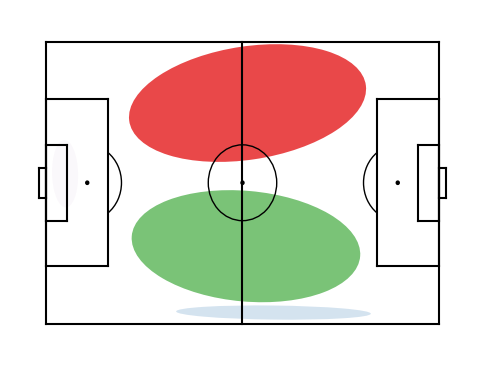

In [33]:
vis.show_location_model(models["classic"])

In [34]:
# Von Mises clusters
k_vm = 3
all_results_vm = []


for init in ["k-means++", "k-means", "random", "random_from_data"]:
    times = {}
    results = {}
    models = {}

    for case in ["classic", "approximation", "bregman"]:
        dir_model = sc.MixtureModel(
            [sc.VonMises() for _ in range(k_vm)],
            init=init
        )
        start = time.time()
        results[case] = dir_model.fit_em(dir_data, verbose=False, case=case)
        times[case] = time.time() - start
        models[case] = dir_model

        all_results_vm.append({
            "initialization": init,
            "case": case,
            "log_likelihood": results[case][-1],
            "time_sec": times[case],
            "ch_score": models[case].kl_ch_score(dir_data)
        })

dir_results = pd.DataFrame(all_results_vm)
dir_results


,initialization,case,log_likelihood,time_sec,ch_score
0,k-means++,classic,-7552.135515,1.489186,0.029275
1,k-means++,approximation,-7105.131313,0.496039,0.018500
2,k-means++,bregman,-7929.646260,0.497945,0.011171
3,k-means,classic,-7552.135515,1.468215,0.029275
4,k-means,approximation,-7105.131313,0.478256,0.018500
5,k-means,bregman,-7929.646260,0.493441,0.011171
6,random,classic,-7798.927642,1.478203,0.021913
7,random,approximation,-7178.661060,0.494811,0.017472
8,random,bregman,-7941.568868,0.461321,0.010789
9,random_from_data,classic,-7552.135515,1.437152,0.029275


In [35]:
for case in ["classic","approximation","bregman"]:
    print(f"{models[case]}\n")

MixtureModel(n_components=3)
  ├─ (0) w=0.325  VonMises(loc=-51.2º, kappa=0.900)
  ├─ (1) w=0.468  VonMises(loc=90.6º, kappa=0.406)
  └─ (2) w=0.207  VonMises(loc=5.9º, kappa=2.293)

MixtureModel(n_components=3)
  ├─ (0) w=0.353  VonMises(loc=-28.7º, kappa=0.845)
  ├─ (1) w=0.597  VonMises(loc=46.5º, kappa=0.331)
  └─ (2) w=0.050  VonMises(loc=0.4º, kappa=10.420)

MixtureModel(n_components=3)
  ├─ (0) w=0.375  VonMises(loc=-10.1º, kappa=0.784)
  ├─ (1) w=0.260  VonMises(loc=145.5º, kappa=0.393)
  └─ (2) w=0.365  VonMises(loc=0.3º, kappa=0.844)



### Two layer scheme

Running a Gaussian mixture model to get location clusters. Then, for each one of the location clusters, run a von Mises mixture model using again all dataset, but for this second step, each datapoint is weighted by the posteriors of the location mixture model.

bregman, k-means++: Time 2.847s, CH Score: 0.1737, BIC Score: 30873


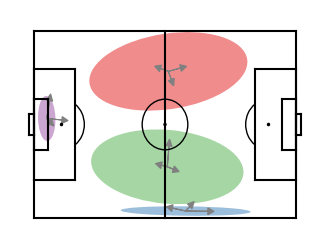

bregman, k-means: Time 2.835s, CH Score: 0.1737, BIC Score: 30873


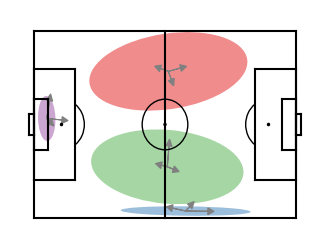

bregman, random: Time 2.701s, CH Score: 0.1462, BIC Score: 30869


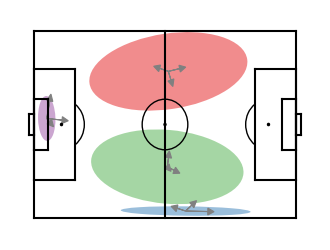

bregman, random_from_data: Time 2.656s, CH Score: 0.1737, BIC Score: 30873


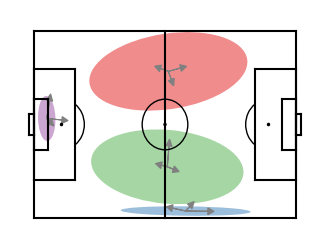

approximation, k-means++: Time 1.970s, CH Score: 0.1509, BIC Score: 30840


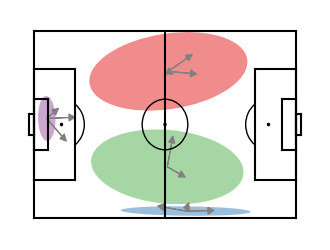

approximation, k-means: Time 1.929s, CH Score: 0.1509, BIC Score: 30840


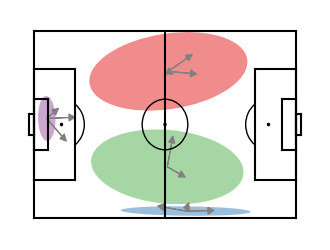

approximation, random: Time 2.232s, CH Score: 0.1555, BIC Score: 30876


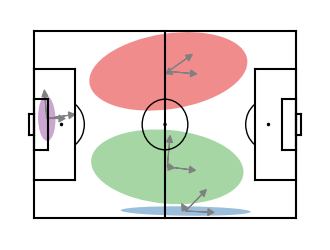

approximation, random_from_data: Time 1.989s, CH Score: 0.1509, BIC Score: 30840


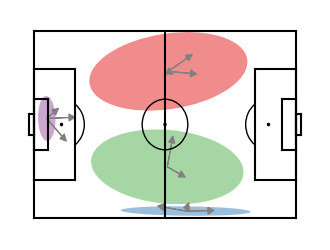

classic, k-means++: Time 6.632s, CH Score: 0.1952, BIC Score: 30837


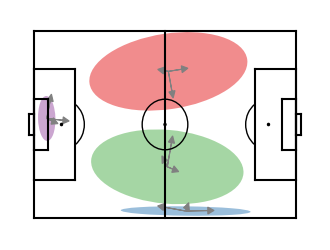

classic, k-means: Time 6.899s, CH Score: 0.1952, BIC Score: 30837


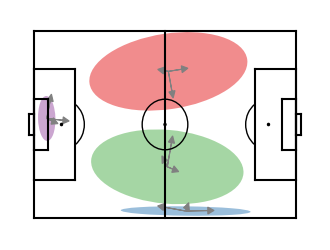

classic, random: Time 6.614s, CH Score: 0.1964, BIC Score: 30889


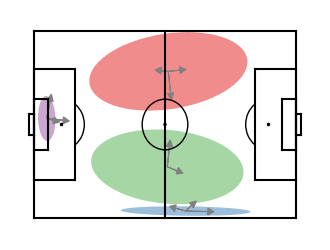

classic, random_from_data: Time 6.408s, CH Score: 0.1952, BIC Score: 30837


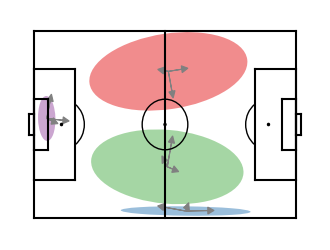

In [36]:
K_loc = 4
K_dir = 3
results = {}
rows = []
for method in ["bregman","approximation","classic"]:
    for init in ["k-means++","k-means","random","random_from_data"]:
        start = time.time()
        results[method] = sc.two_layer_scheme(loc_data,
                                              dir_data,
                                              K_loc,
                                              K_dir,
                                              choose=method,
                                              init=init)
        run_time = time.time() - start
        ch_score = sum([results[method][1][i].kl_ch_score(dir_data) for i in range(K_dir)])
        bic_score = sum([results[method][1][i].bic_score(dir_data) for i in range(K_dir)])
        print(f"{method}, {init}: Time {run_time:.3f}s, CH Score: {ch_score:.4f}, BIC Score: {bic_score:.0f}")
        rows.append({
            "method": method,
            "init": init,
            "running_time": round(run_time,2),
            "ch_score" : round(ch_score,5),
            "bic_score" : round(bic_score,0)
        })
        gmm, vmm = results[method]
        vis.show_all_models(gmm, vmm, figsize=4)

two_layer_results = pd.DataFrame(rows)

In [37]:
two_layer_results

,method,init,running_time,ch_score,bic_score
0,bregman,k-means++,2.85,0.17374,30873.0
1,bregman,k-means,2.84,0.17374,30873.0
2,bregman,random,2.70,0.14617,30869.0
3,bregman,random_from_data,2.66,0.17374,30873.0
4,approximation,k-means++,1.97,0.15089,30840.0
5,approximation,k-means,1.93,0.15089,30840.0
6,approximation,random,2.23,0.15548,30876.0
7,approximation,random_from_data,1.99,0.15089,30840.0
8,classic,k-means++,6.63,0.19521,30837.0
9,classic,k-means,6.90,0.19521,30837.0


In [38]:
vmm[3]

MixtureModel(n_components=3)
  ├─ (0) w=0.545  VonMises(loc=-5.8º, kappa=2.395)
  ├─ (1) w=0.200  VonMises(loc=-22.5º, kappa=0.891)
  └─ (2) w=0.256  VonMises(loc=77.9º, kappa=2.378)